# Read before doing anything
We found an error in the training dataset 2 (there was a whitespace in front of each feature name). Therefore we preprocessed and fixed it. Our files have been renamed and they are as follows:
* ./data/trn_set_1.csv --> BATADAL_dataset03.csv
* ./data/trn_set_2.csv --> BATADAL_dataset04.csv
* ./data/test_set.csv --> BATADAL_test_dataset.csv

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from pandas.plotting import autocorrelation_plot
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import numpy as np
sns.set()

In [2]:
import warnings
# warnings.filterwarnings("ignore")

In [3]:
file_name = "trn_set_1"
DATA_PATH = r"C:../data/{}.csv".format(file_name)

data = pd.read_csv(DATA_PATH, header=0, parse_dates=['DATETIME'], index_col='DATETIME', dayfirst=True)
data.index = pd.DatetimeIndex(data.index.values, freq = data.index.inferred_freq)

First, we need to choose the signal we want to process and test whether they are stationary or not. 

The documentation of the competition highlights the importance of an ideal detection mechanism being able to identify which physical components of the network are being attacked. Considering this motivation, we decided to choose as three of the analyzed sensors for the ARMA model the water level in all towers ('L\_T1' to 'L\_T3'). Additionally, we also analyzed three flow signals, namely 'F\_PU1', 'F\_PU2' and 'F\_PU10'.

In [4]:
names = ['L_T1', 'L_T2', 'L_T3', 'F_PU1', 'L_T4', 'F_PU10']

In [5]:
signals = {} # signals we want to model with ARMA
for name in names:
    series = pd.Series(data[name], data.index)
    signals[name] = series
    display(series.head(2))

2014-01-06 00:00:00    0.50973
2014-01-06 01:00:00    0.41258
Freq: H, Name: L_T1, dtype: float64

2014-01-06 00:00:00    2.049003
2014-01-06 01:00:00    2.009072
Freq: H, Name: L_T2, dtype: float64

2014-01-06 00:00:00    3.191145
2014-01-06 01:00:00    3.642565
Freq: H, Name: L_T3, dtype: float64

2014-01-06 00:00:00    98.998444
2014-01-06 01:00:00    99.095901
Freq: H, Name: F_PU1, dtype: float64

2014-01-06 00:00:00    2.792634
2014-01-06 01:00:00    2.831673
Freq: H, Name: L_T4, dtype: float64

2014-01-06 00:00:00    30.512712
2014-01-06 01:00:00    30.480455
Freq: H, Name: F_PU10, dtype: float64

Let's first do the analysis visually, by plotting them. We can observe that all of them have visually constant statistical properties (mean, variance, autocorrelation) over time, so they seem to be stationary. However, let's also perform a statistical test to make sure.



Processing signal 'L_T1'


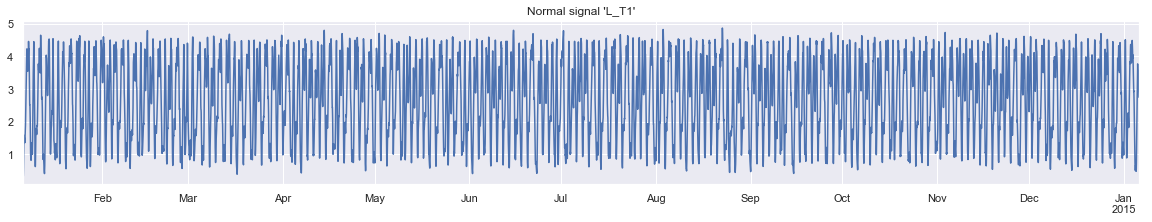



Processing signal 'L_T2'


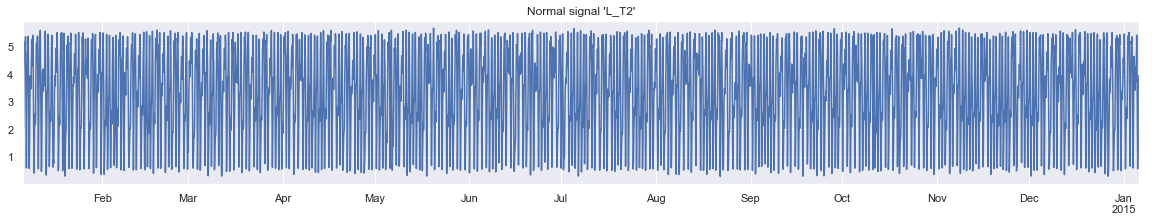



Processing signal 'L_T3'


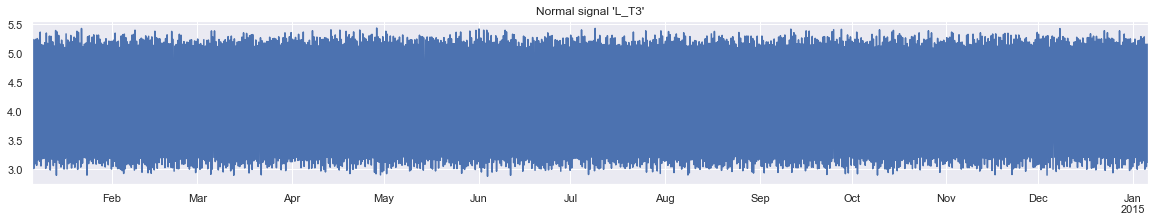



Processing signal 'F_PU1'


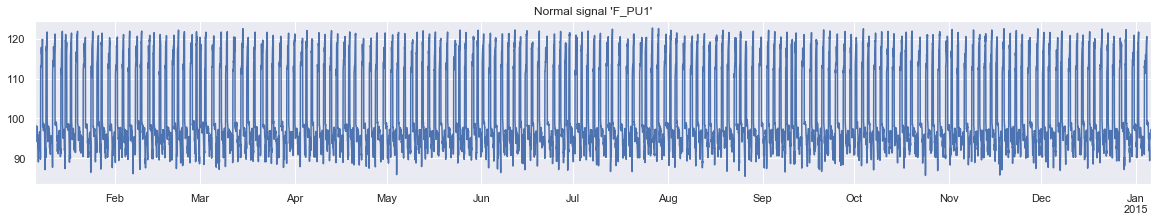



Processing signal 'L_T4'


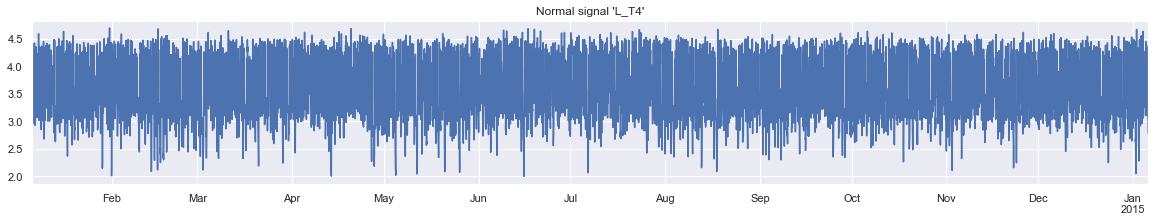



Processing signal 'F_PU10'


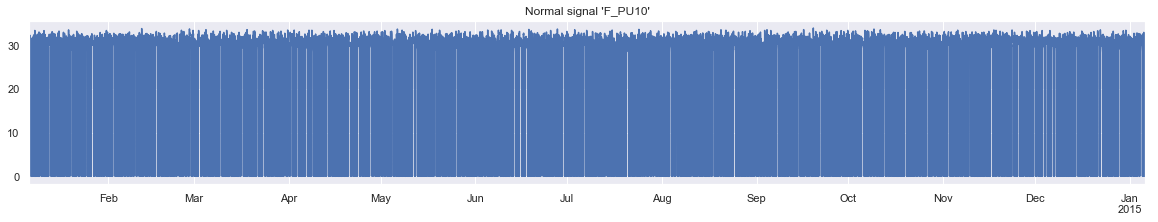

In [6]:
for signal in signals.keys():
    print(f"\n\nProcessing signal '{signal}'")
    
    series = signals[signal]
    
    # visualize it
    series.plot(figsize=(20,3))
    plt.title(f"Normal signal '{signal}'")
    plt.show()
    
    # do not uncomment. Differencing has been shown not necessary
    #stationary = difference(series)

    # visualize it
    #stationary.plot(figsize=(20,3))
    #plt.title(f"Stationary signal '{signal}'")
    #plt.show()
              
    #signals[signal] = stationary

Let's use the Augmented Dickey–Fuller test for testing stationarity stationarity. We will use a confidence level of 0.05.

For this test, the hypotheses are the following:
    - Null Hypothesis (H0): The time series has a unit-root and is non-stationary.
    - Alternative Hypothesis (H1): The time series does not have a unit-root and, thus, it is stationary.
    
If the p-values we obtain from the test are below our considered confidence level of 0.05, then we reject the Null Hypothesis, H0, meaning that our data is stationary.

Let's have a look at the results!

In [7]:
from statsmodels.tsa.stattools import adfuller


for signal in signals.keys():
    print(f"\n\nTesting stationarity for '{signal}'")
    
    result = adfuller(signals[signal])
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))



Testing stationarity for 'L_T1'
ADF Statistic: -20.615633
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


Testing stationarity for 'L_T2'
ADF Statistic: -18.612726
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


Testing stationarity for 'L_T3'
ADF Statistic: -14.375782
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


Testing stationarity for 'F_PU1'
ADF Statistic: -27.596471
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


Testing stationarity for 'L_T4'
ADF Statistic: -16.582866
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


Testing stationarity for 'F_PU10'
ADF Statistic: -16.463434
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


We can observe that all the p-value we obtain are significantly lower than 0.05 and, thus, all the considered signals are **stationary**. We can now proceed with the ARMA analysis.

### Plot ACF and PACF of the signal, to retrieve the values of p and q of the ARMA



Computing ACF and PACF for 'L_T1'


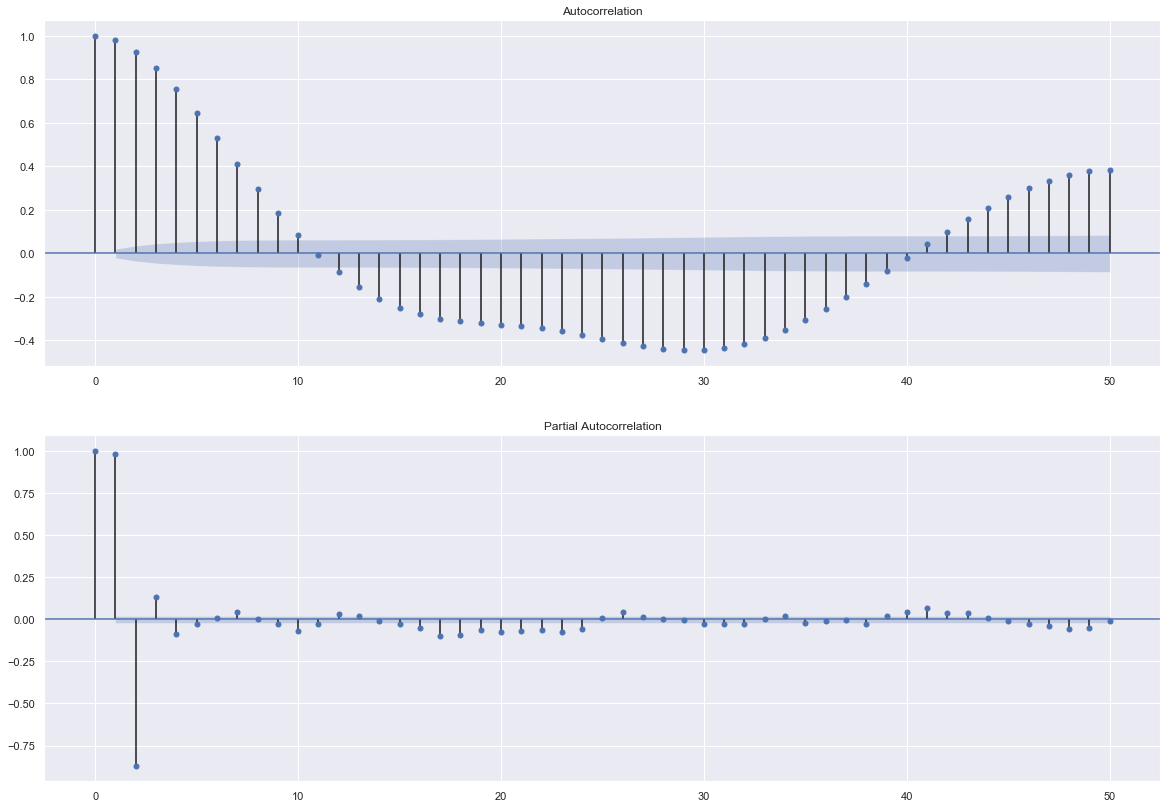



Computing ACF and PACF for 'L_T2'


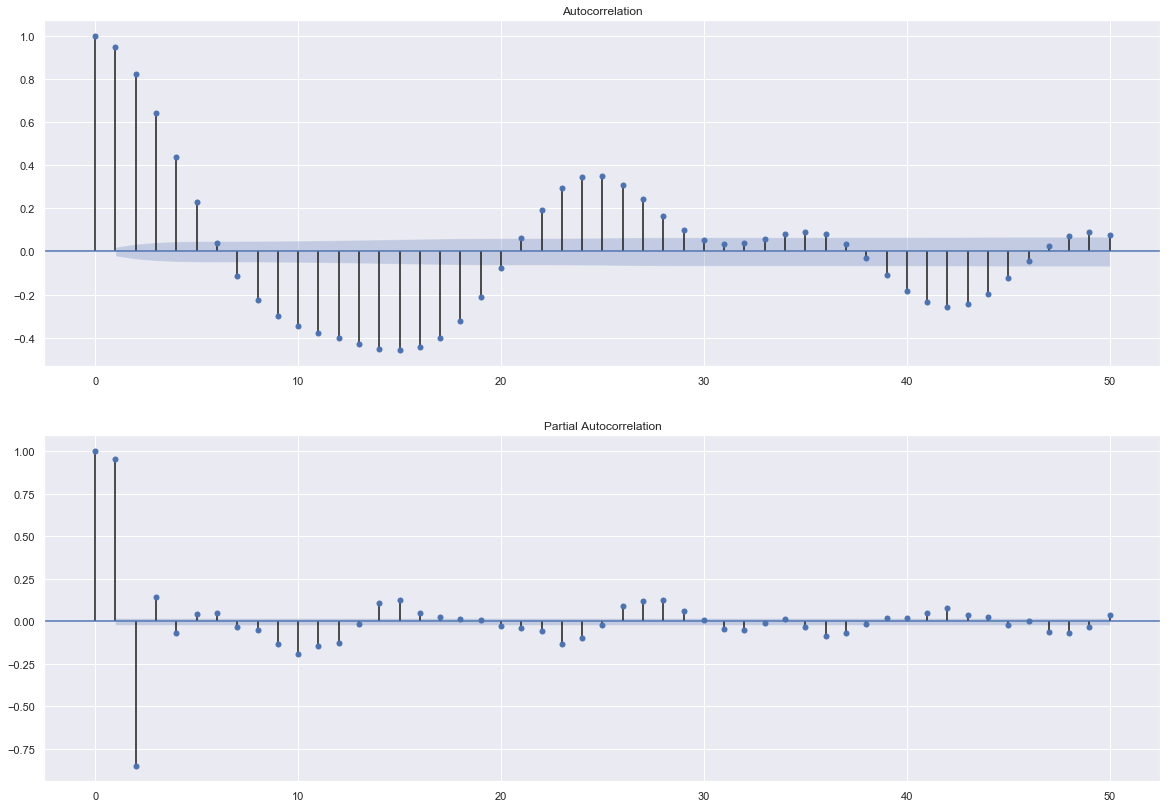



Computing ACF and PACF for 'L_T3'


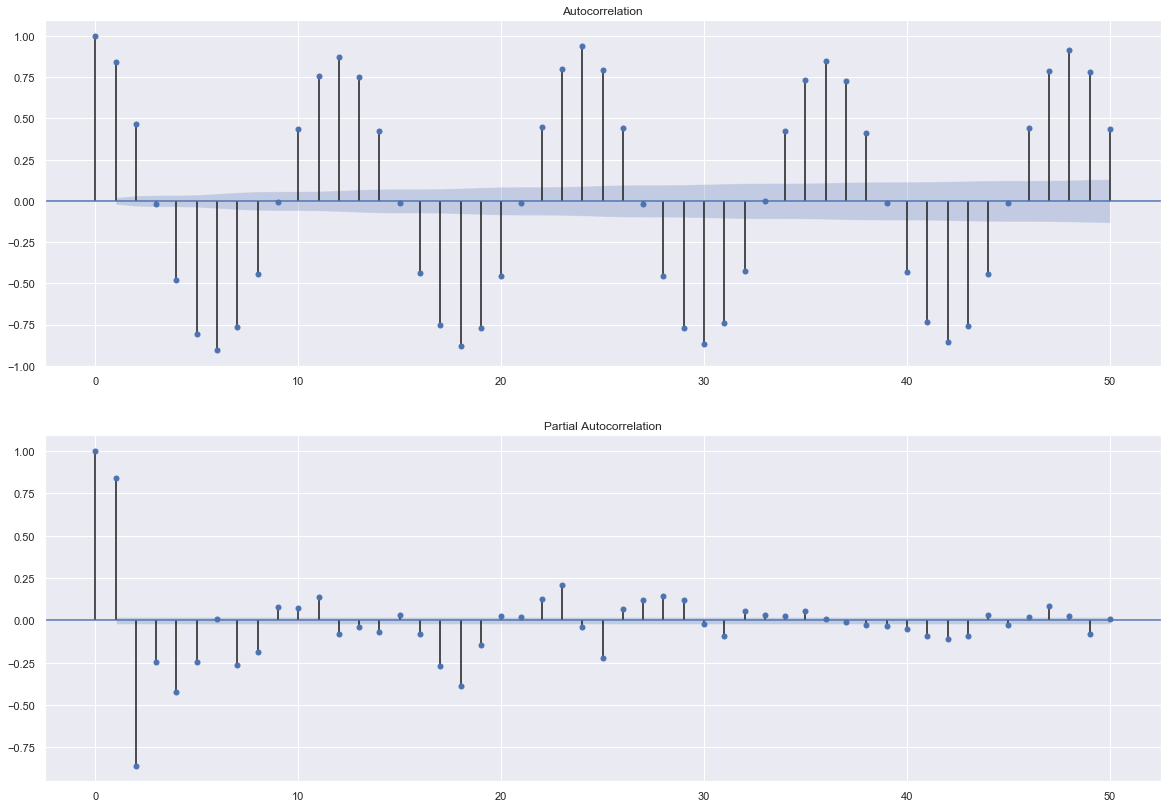



Computing ACF and PACF for 'F_PU1'


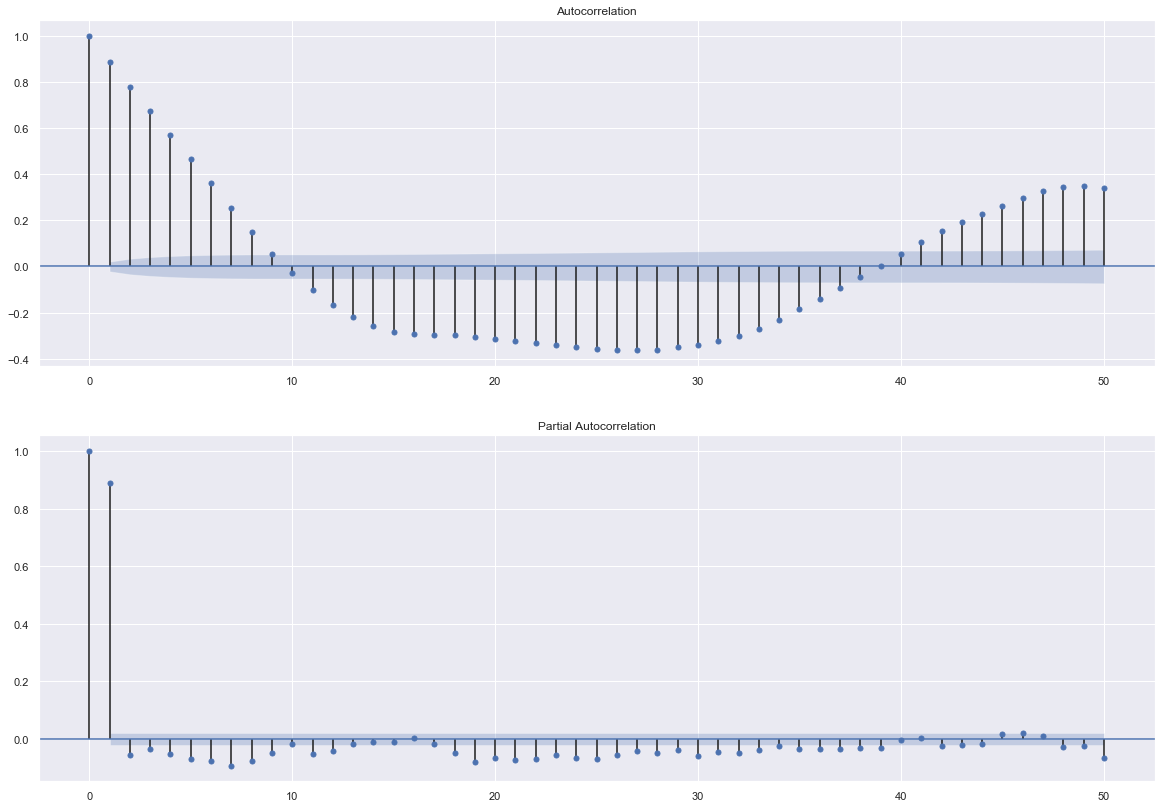



Computing ACF and PACF for 'L_T4'


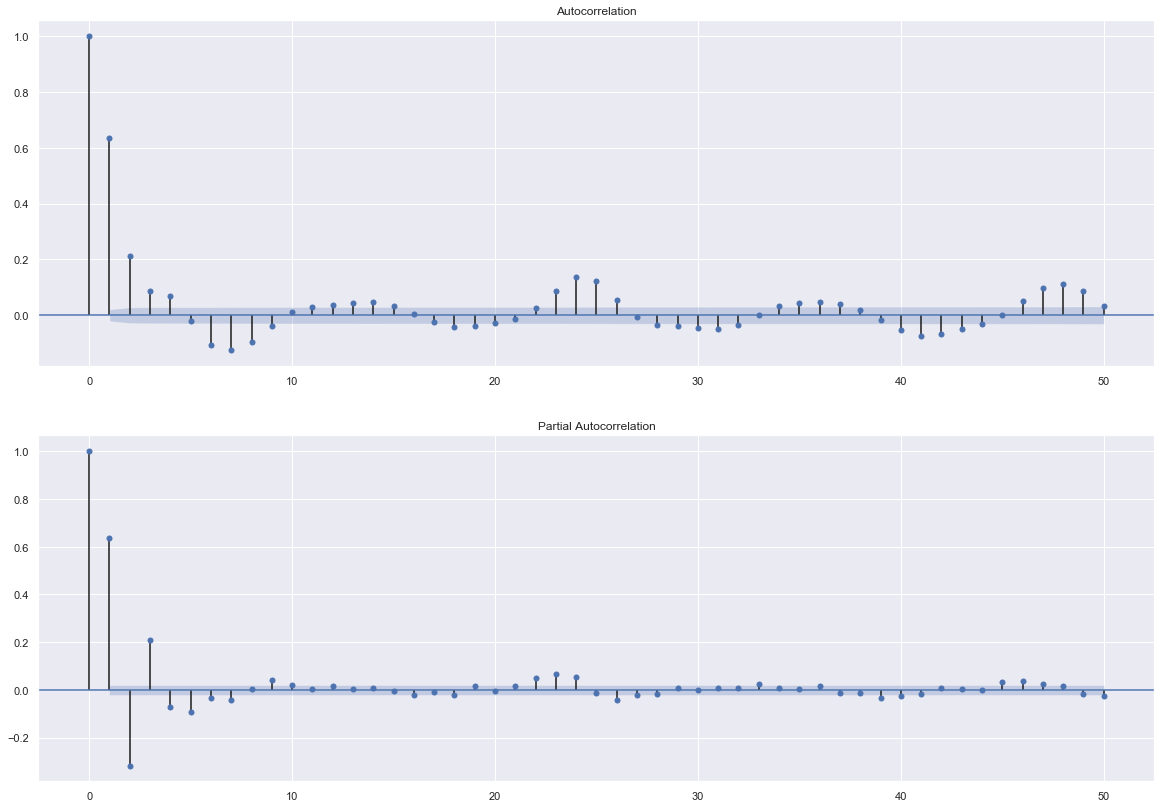



Computing ACF and PACF for 'F_PU10'


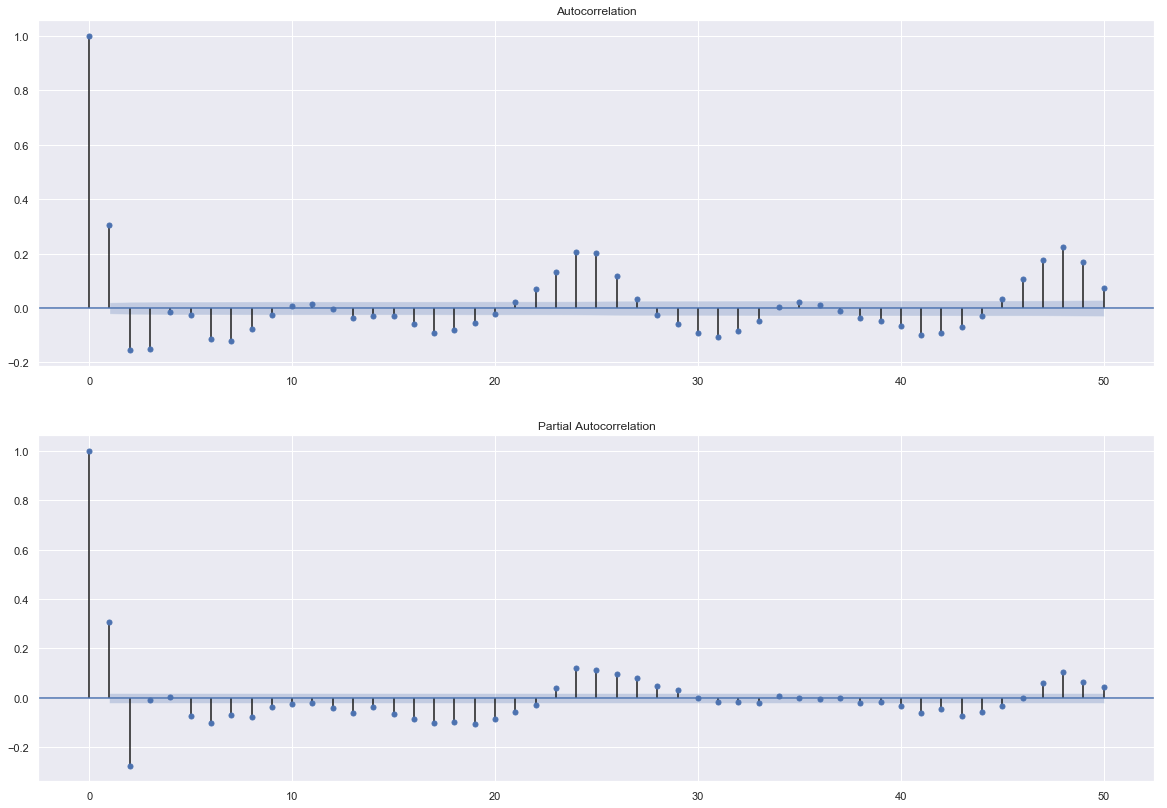

In [8]:
for signal in signals.keys():
    print(f"\n\nComputing ACF and PACF for '{signal}'")
    
    series = signals[signal]
    
    fig = plt.figure(figsize=(20,14))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(series, lags=50, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(series, lags=50, ax=ax2)
    plt.show()

By looking at the plot, we should choose the following orders for the signals:
    - p=11 and q=6 for L_T1
    - p=6 and q=13 for L_T2
    - p=3 and q=6 for L_T3
    - p=10 and q=10 for F_PU1
    - p=10 and q=13 for F_PU2
    - p=4 and q=3 for F_PU10

## Grid Search

In [9]:
import warnings
import pandas as pd
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

In [10]:
import warnings
# warnings.filterwarnings("ignore")

Now we can define a function for evaluating the different parameters for the ARMA model, based on either MSE or AIC. 

In [11]:
#resource: https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/
def evaluate_arima_model_mse(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    error = np.mean(aics)
    return error

def evaluate_arima_model_aic(X, arima_order):
    model = ARIMA(X, order=arima_order)
    model_fit = model.fit(disp=0)
    return model_fit.aic

Now we define a method that loops over different sets of parameters for ARMA and evaluates the performance based on AIC.

In [12]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    #error = evaluate_arima_model_mse(dataset, order)
                    error = evaluate_arima_model_aic(dataset, order)
                    if error < best_score:
                        best_score, best_cfg = error, order
                    #print('ARIMA%s MSE=%.3f' % (order,error))
                    print('ARIMA%s AIC=%.3f' % (order,error))
                except:
                    continue # the try/catch is done because the optimization can fail: https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/
    #print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
    print('Best ARIMA%s AIC=%.3f' % (best_cfg, best_score))

We have to define a dictionary with values to test for the different signals.

In [13]:
#Format of the dictionary elements: Sjgnal_name:[p_list, d_list, q_list]
# this is based on what we found with using ACF and PACF
params = {'L_T1':[[8,9,10,11,12,13], [0], [3,4,5,6,7,8]],
         'L_T2': [[3,4,5,6,7,8], [0], [10,11,12,13,14,15]],
         'L_T3': [[1,2,3,4,5], [0], [3,4,5,6,7,8]],
         'F_PU1': [[7,8,9,10,11,12], [0], [7,8,9,10,11,12]],
         'L_T4': [[2,3,4,5,6,7], [0], [5,6,7,8,9,10]],
         'F_PU10': [[1,2,3,4,5,6], [0], [1,2,3,4,5]]}

In [ ]:
# evaluate parameters
warnings.filterwarnings("ignore")

# this TAKES A LOT, run it only if you really really really want to
for signal in signals.keys():
    print(f"\n\nComputing AIC values for '{signal}'")    
    series = signals[signal]
    p_values = params[signal][0]
    d_values = params[signal][1]
    q_values = params[signal][2]
    evaluate_models(series.values, p_values, d_values, q_values)



Computing AIC values for 'L_T1'
ARIMA(8, 0, 3) AIC=-13548.014
ARIMA(8, 0, 4) AIC=-13550.346
ARIMA(8, 0, 5) AIC=-13548.391
ARIMA(8, 0, 6) AIC=-13547.138
ARIMA(8, 0, 7) AIC=-13639.632
ARIMA(8, 0, 8) AIC=-13644.722
ARIMA(9, 0, 3) AIC=-13513.509
ARIMA(9, 0, 4) AIC=-13549.030
ARIMA(9, 0, 5) AIC=-13546.934
ARIMA(9, 0, 6) AIC=-13564.819
ARIMA(9, 0, 7) AIC=-13645.654
ARIMA(9, 0, 8) AIC=-13645.471
ARIMA(10, 0, 3) AIC=-13521.655
ARIMA(10, 0, 4) AIC=-13551.281
ARIMA(10, 0, 5) AIC=-13672.575
ARIMA(10, 0, 7) AIC=-13722.064
ARIMA(10, 0, 8) AIC=-13756.880
ARIMA(11, 0, 3) AIC=-13524.442
ARIMA(11, 0, 4) AIC=-13577.853
ARIMA(11, 0, 6) AIC=-13582.897
ARIMA(11, 0, 7) AIC=-13667.142
ARIMA(12, 0, 3) AIC=-13815.077
ARIMA(12, 0, 4) AIC=-13813.150
ARIMA(12, 0, 5) AIC=-13812.549
ARIMA(12, 0, 7) AIC=-13921.049
ARIMA(12, 0, 8) AIC=-13755.333
ARIMA(13, 0, 3) AIC=-13744.026
ARIMA(13, 0, 4) AIC=-13799.403
ARIMA(13, 0, 5) AIC=-13798.786
ARIMA(13, 0, 6) AIC=-13798.298
Best ARIMA(12, 0, 7) AIC=-13921.049


Computing 

Because of the way AIC works, it is likely to select a very complex model when testing too many models (). This is the case, where AIC suggests us to select the most complex model.    

If we look carefully to the values of AIC, though, we can see how there is a big drop when 'q' goes from 0 to 1. After this moment, the value of AIC goes down very slowly, suggesting that the added value of using a more complex parameter is not significant.   

We analyse for each signal where the drops happens, and we will use that order for the following steps

In [ ]:
# values taken by grid search above
orders = {
    'L_T1': (11, 0, 6),
    'L_T2': (4, 0, 10),
    'L_T3': (2, 0, 4),
    'L_T4': (5, 0, 8),
    'F_PU1': (10, 0, 8),
    'F_PU10': (4, 0, 3),
}

In [ ]:
# https://github.com/statsmodels/statsmodels/issues/2788 SARIMAX is needed to include new observations in time
def make_predictions_sarimax(trn_series, tst_series, order):
    mod_trn = sm.tsa.SARIMAX(trn_series, order=order, enforce_invertibility=False, enforce_stationarity=False)
    res_trn = mod_trn.fit(disp=0)
    
    predictions = []
    start_idx = tst_series.index[0]
    
    for tst_idx in tst_series.index:
        mod_tst = sm.tsa.SARIMAX(tst_series[start_idx:tst_idx], order=order)
        res_tst = mod_tst.filter(res_trn.params)
        output = res_tst.forecast(1)
        predictions.append(output.values)
        
    return predictions
    

We choose training set 1 to fit our ARMA. This is because there are no attacks in this training set --> we can learn the normal behaviour

In [ ]:
for signal in signals.keys():
    print(f"Predicting and plotting prediction for '{signal}'")
    signal_data = signals[signal]
    #print("{} data points for signal '{}'".format(signal_data.shape[0], signal))
    #print(signal_data.head(5))
    
    signal_data.loc['2014-12'].plot(figsize=(20, 3), title=f"Overview of {signal} (1 month only)")
    plt.show()
    
    hours_to_predict = 24 * 7 * 6
    split_point = len(signal_data) - hours_to_predict 

    train = signal_data.iloc[0:split_point]
    test = signal_data.iloc[split_point:]
    print(f"{train.shape[0]} hours used for training, {test.shape[0]} for testing.")

    predictions = make_predictions_sarimax(train, test, orders[signal])

    plt.figure(figsize=(20,3))
    plt.plot(test.values, color='blue', label='Observed')
    plt.plot(predictions, color='red', label='Predicted')
    plt.title(f"Predictions for signal '{signal}' for {hours_to_predict} hours. Order: {orders[signal]}")
    plt.legend()
    plt.show()
    
    print(f"MSE: {mean_squared_error(test.values, predictions)}")

### Thresholding to find anomalies

In [ ]:
file_name = "trn_set_2"
DATA_PATH = r"C:../data/{}.csv".format(file_name)

data_trn_2 = pd.read_csv(DATA_PATH, header=0, parse_dates=['DATETIME'], index_col='DATETIME', dayfirst=True)
data_trn_2.index = pd.DatetimeIndex(data_trn_2.index.values, freq = data_trn_2.index.inferred_freq)

Let's just look at an overview of the signals we are working with, in the second dataset (we also plot the attack labels)

In [ ]:
axes = data_trn_2[names + ['ATT_FLAG']].plot(figsize=(17, 3*8), subplots=True) 
plt.show()

In [ ]:
test_signals = {}

for name in names:
    series = pd.Series(data_trn_2[name], data_trn_2.index)
    test_signals[name] = series
    display(series.head(2))

In [ ]:
for test_signal in test_signals.keys():
    print(f"\n\nProcessing signal '{test_signal}'")
    
    test_series = test_signals[test_signal]
    
    # visualize it
    test_series.plot(figsize=(20,3))
    plt.title(f"Normal signal '{test_signal}'")
    plt.show()
    
    #test_stationary = difference(test_series)

    # visualize it
    #test_stationary.plot(figsize=(20,3))
    #plt.title(f"Stationary signal '{test_signal}'")
    #plt.show()
              
    #test_signals[test_signal] = test_stationary

## Detection!

In [ ]:
def make_detection_sarimax(trn_series, tst_series, order):
    
    new_test = tst_series.copy()
    
    mod_trn = sm.tsa.SARIMAX(trn_series, order=order, enforce_invertibility=False, enforce_stationarity=False)
    res_trn = mod_trn.fit(disp=0)
    
    predictions = []
    residuals = []
    start_idx = new_test.index[0]
    count = 0
    for tst_idx in new_test.index:
        mod_tst = sm.tsa.SARIMAX(new_test[start_idx:tst_idx], order=order)
        res_tst = mod_tst.filter(res_trn.params)
        output = res_tst.forecast(1)
        predictions.append(output.values)
        residual = (output.values - new_test[tst_idx])**2
        residuals.append(residual)
#         if residual > threshold:
#             # keep predicting on predicted rather than observed (observed is anomalous!)
#             count += 1
#             new_test[tst_idx] = 0            
#     print(f"{count} residuals above threshold")

    return pd.Series(predictions, new_test.index), pd.Series(residuals, new_test.index)

To tune the threshold for the residuals, we use the MSE obtained during training (on normal behaviour) and then we perform grid search on a range of multipliers.

In [ ]:
# values obtained during training (dataset 1) on normal behaviour.
mean_squared_errors = {
    'L_T1': 0.0419,
    'L_T2': 0.1568,
    'L_T3': 0.088,
    'F_PU1': 1.1596,
    'F_PU10': 82.1452,
    'L_T4': 0.0525,
}

In [ ]:
def get_conf_mat_entry(results, true_attack, pred_attack):
    # just a helper function to retrieve entries of the confusion matrix
    result = results[
        (results['true'] == (1 if true_attack else 0)) 
        & 
        (results['pred'] == (1 if pred_attack else 0))
    ]
    return result.shape[0]

## Gridsearch on threshold value, per signal.

In [ ]:
thres_multipliers = np.linspace(1, 12, 20)
labels = data_trn_2['ATT_FLAG'].map({-999:0, 1:1})
beta = 0.25


for signal in signals.keys():
    fbeta_best = 0
    threshold_best = 0
    mult_best = 0
    best_t_p = 0
    best_f_p = 0
    best_t_n = 0
    best_f_n = 0
    best_prec = 0
    best_rec = 0
    best_detection = None
    
    print(f"\n------------------------------------\n\nPredicting '{signal}'")
    signal_data = signals[signal]
    test_signal = test_signals[signal]

    train = signal_data
    test = test_signal
    print(f"{train.shape[0]} hours used for training, {test.shape[0]} for testing.")

    predictions, residuals = make_detection_sarimax(train, test, orders[signal])
    
    for mult in thres_multipliers:
        threshold = mult * mean_squared_errors[signal]        
        
        detection = pd.DataFrame(np.zeros(test.size), test.index)
        detection[residuals>threshold] = 1
        
        res = pd.concat([labels[detection.index], detection], axis=1) # only take labels when predicted
        res.columns = ['true', 'pred']
        res.set_index(detection.index)
                
        t_p = get_conf_mat_entry(res, true_attack=True, pred_attack=True)
        t_n = get_conf_mat_entry(res, true_attack=False, pred_attack=False)
        f_p = get_conf_mat_entry(res, true_attack=False, pred_attack=True)
        f_n = get_conf_mat_entry(res, true_attack=True, pred_attack=False)

        try:
            precision = t_p/(t_p + f_p)
        except:
            continue
        
        try:
            recall = t_p/(t_p + f_n)                
        except:
            continue
            
        if (precision + recall ) == 0:
            continue

        
        fbeta = ( 1 + (beta**2)) * ( precision * recall ) / ((beta**2) * precision + recall )
                
        if fbeta > fbeta_best:
            # save all the parameters for the best fbeta score
            fbeta_best = fbeta
            threshold_best = threshold
            best_t_p = t_p
            best_f_p = f_p
            best_t_n = t_n
            best_f_n = f_n
            best_prec = precision
            best_rec = recall
            best_detection = detection
            mult_best = mult

    # per signal
    best_data = {
        'mult': mult_best,
        'threshold': threshold_best,
    }
    signals[signal]['best'] = best_data
    
    print("Displaying results")
    
    plt.figure(figsize=(17,2))
    plt.plot(data_trn_2[signal], color='blue', label='Original signal')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(17,2))
    plt.plot(residuals, color='red', label='Residuals')
    threshold_series = pd.DataFrame(np.array([threshold_best for i in range(residuals.shape[0])]), residuals.index)
    plt.plot(threshold_series, color='green', label='Threshold for residuals')
    plt.yscale("log")
    plt.legend()
    plt.show()

    plt.figure(figsize=(17,2))
    plt.plot(best_detection, color='green', label='Detection')
    plt.plot(labels, color='red', label='True label')
    plt.legend()
    plt.show()  
    print(f"Best threshold for signal {signal}: {threshold_best}. F{beta}: {fbeta_best}")
    print(f"TP: {best_t_p}. FP:{best_f_p}. TN:{best_t_n}. FN: {best_f_n}")
    print(f"Prec: {best_prec}, Rec: {best_rec}")
